In [1]:
# Description: create and plot multiple technical indicators, train LSTM model to predict stock price


In [2]:
# import libs
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

In [3]:
# define stock ticker
TICKER = 'FB'

# start and end dates
start_date = '2012-05-18' # date of FB's IPO
end_date = '2021-01-01'

# load and store the data
df = web.DataReader(TICKER, data_source='yahoo', start=start_date, end=end_date)
# show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999


In [4]:
# create functions to calculate SMA simple moving average and EMA exponential moving average

# sma
def SMA(data, period=30, column='Close'):
    return data[column].rolling(window=period).mean()

# ema
def EMA(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [5]:
# calculate MACD (moving average convergence/divergence)
def MACD(data, period_long=26, period_short=12, period_signal=9, column='Close'):
    # Calculate the short term EMA
    short_ema =  EMA(data, period_short, column=column)
    # calculate long term EMA
    long_ema = EMA(data, period_long, column=column)
    # calculate the moving average convergence/divergence (MACD)
    data['MACD'] = short_ema - long_ema
    # calculate the signal line
    data['Signal_Line'] = EMA(data, period_signal, column='MACD')

    return data

In [6]:
# Create relative strength index (RSI) 
def RSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta[1:]
    up = delta.copy()
    down = delta.copy()
    up[up<0] = 0
    down[down>0] = 0
    data['up'] = up
    data['down'] = down
    avg_gain = SMA(data, period, column='up')
    avg_loss = abs(SMA(data, period, column='down'))
    rs = avg_gain/avg_loss
    rsi = 100.0 - (100.0/(1.0 + rs))

    data['RSI'] = rsi

    return data

In [7]:
# add to the data set
MACD(df)
RSI(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)

In [8]:
# show the data
df

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal_Line,up,down,RSI,SMA,EMA
Date,,,,,,,,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000,0.000000,0.000000,NaN,NaN,NaN,NaN,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999,-0.335043,-0.067009,0.000000,-4.200001,NaN,NaN,37.829999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000,-0.835432,-0.220693,0.000000,-3.029999,NaN,NaN,37.179523
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000,-1.138182,-0.404191,1.000000,0.000000,NaN,NaN,36.686235
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999,-1.280243,-0.579401,1.029999,0.000000,NaN,NaN,36.338022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994,-1.908274,-0.484116,0.000000,-0.709991,32.006975,276.039666,274.323301
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000,-1.433083,-0.673909,9.600006,0.000000,38.680755,276.103666,274.578225
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999,-1.062002,-0.751528,0.000000,-0.220001,40.790213,276.097999,274.787918


In [9]:
# drop NaN rows
df = df.dropna()
df

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal_Line,up,down,RSI,SMA,EMA
Date,,,,,,,,,,,,,
2012-06-29,31.990000,30.760000,31.920000,31.100000,19526900,31.100000,-0.075133,-0.574575,0.000000,-0.260000,68.675818,30.239333,31.135125
2012-07-02,31.730000,30.549999,31.250000,30.770000,14122000,30.770000,-0.109647,-0.481590,0.000000,-0.330000,65.472929,29.990667,31.100351
2012-07-03,31.440001,30.799999,30.910000,31.200001,8763600,31.200001,-0.101137,-0.405499,0.430000,0.000000,67.560337,29.896333,31.109841
2012-07-05,31.629999,31.020000,31.320000,31.469999,10032100,31.469999,-0.071778,-0.338755,0.269999,0.000000,65.229893,29.912000,31.144142
2012-07-06,31.900000,31.260000,31.440001,31.730000,10945600,31.730000,-0.027217,-0.276447,0.260000,0.000000,59.576844,29.903000,31.199938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994,-1.908274,-0.484116,0.000000,-0.709991,32.006975,276.039666,274.323301
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000,-1.433083,-0.673909,9.600006,0.000000,38.680755,276.103666,274.578225
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999,-1.062002,-0.751528,0.000000,-0.220001,40.790213,276.097999,274.787918


In [10]:
# drop unnecessary columns
df = df.filter(['Close', 'MACD', 'Signal_Line', 'RSI', 'SMA', 'EMA'])
df


,Close,MACD,Signal_Line,RSI,SMA,EMA
Date,,,,,,
2012-06-29,31.100000,-0.075133,-0.574575,68.675818,30.239333,31.135125
2012-07-02,30.770000,-0.109647,-0.481590,65.472929,29.990667,31.100351
2012-07-03,31.200001,-0.101137,-0.405499,67.560337,29.896333,31.109841
2012-07-05,31.469999,-0.071778,-0.338755,65.229893,29.912000,31.144142
2012-07-06,31.730000,-0.027217,-0.276447,59.576844,29.903000,31.199938
...,...,...,...,...,...,...
2020-12-24,267.399994,-1.908274,-0.484116,32.006975,276.039666,274.323301
2020-12-28,277.000000,-1.433083,-0.673909,38.680755,276.103666,274.578225
2020-12-29,276.779999,-1.062002,-0.751528,40.790213,276.097999,274.787918


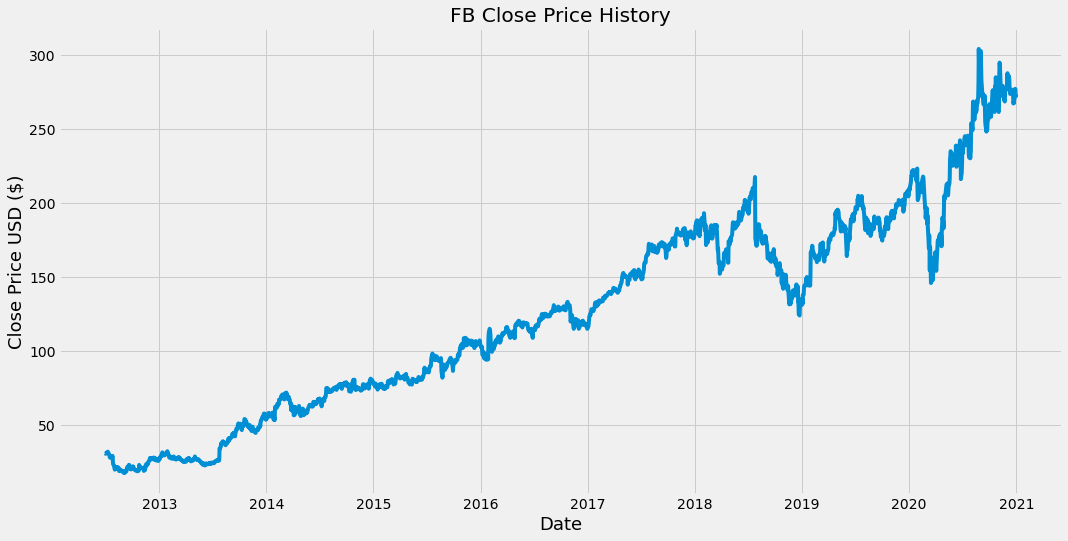

In [11]:
# Plot closing Price
plt.figure(figsize=(16,8))
plt.title('{} Close Price History'.format(TICKER))
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

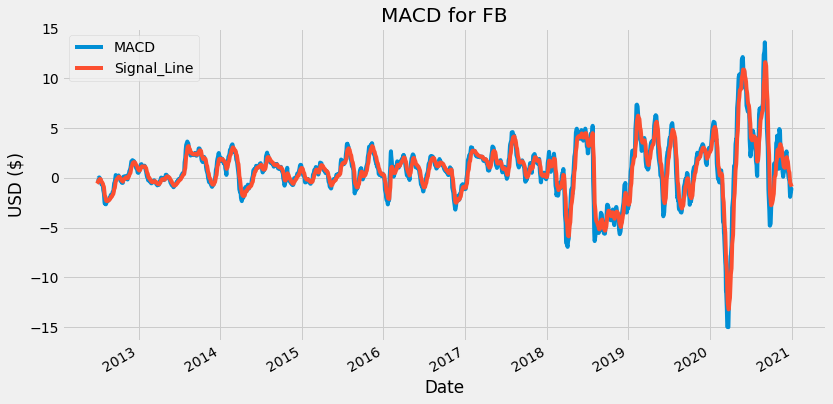

In [12]:
# plot the charts
# create a list of columns to keep
column_list = ['MACD', 'Signal_Line']
df[column_list].plot(figsize=(12.2,6.4))
plt.title('MACD for ' + TICKER)
plt.ylabel('USD ($)')
plt.xlabel('Date')
plt.show()

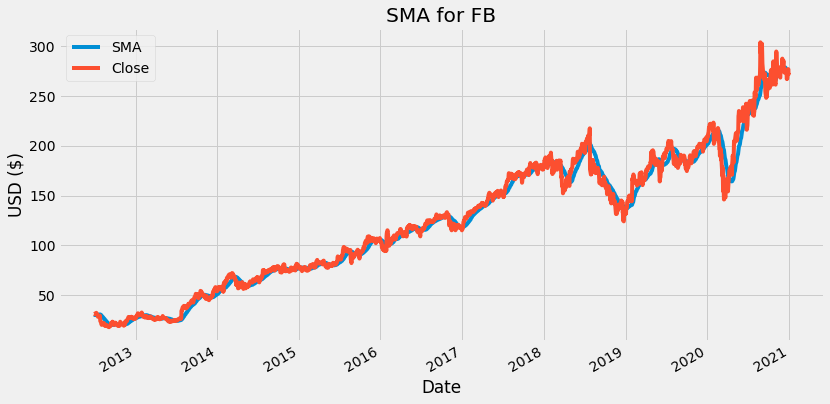

In [13]:
# plot the charts
# create a list of columns to keep
column_list = ['SMA', 'Close']
df[column_list].plot(figsize=(12.2,6.4))
plt.title('SMA for ' + TICKER)
plt.ylabel('USD ($)')
plt.xlabel('Date')
plt.show()

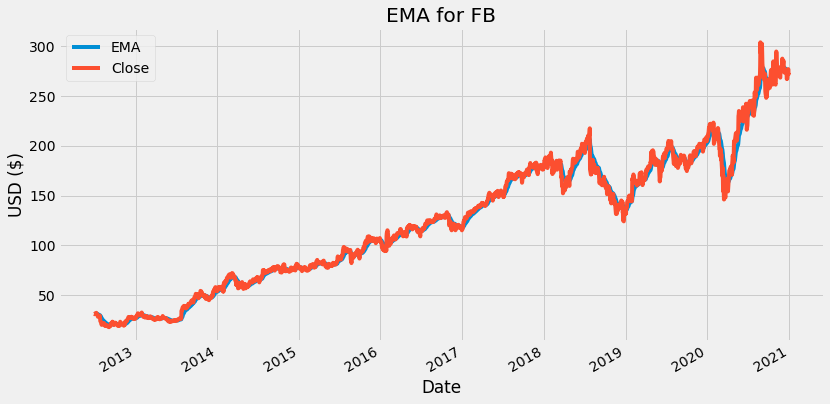

In [14]:
# plot the charts
# create a list of columns to keep
column_list = ['EMA', 'Close']
df[column_list].plot(figsize=(12.2,6.4))
plt.title('EMA for ' + TICKER)
plt.ylabel('USD ($)')
plt.xlabel('Date')
plt.show()

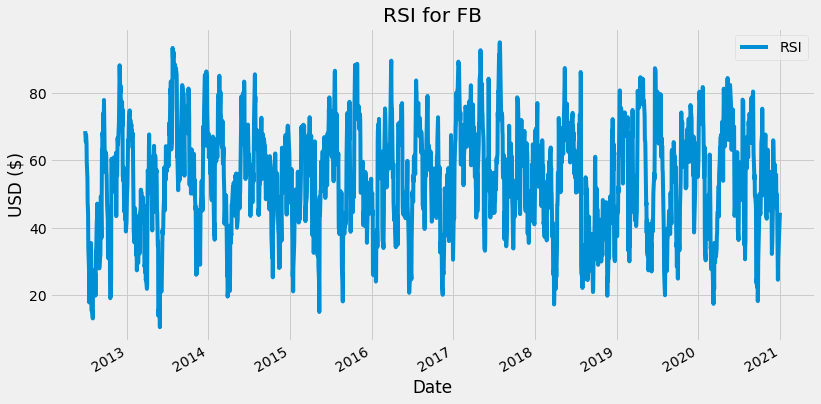

In [15]:
# plot the charts
# create a list of columns to keep
column_list = ['RSI']
df[column_list].plot(figsize=(12.2,6.4))
plt.title('RSI for ' + TICKER)
plt.ylabel('USD ($)')
plt.xlabel('Date')
plt.show()

In [16]:
# print shape of df
df.shape

(2141, 6)

In [17]:
# convert df to np array
dataset = df.values

# get number of rows to train model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

1713

In [18]:
# scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04671885, 0.52150539, 0.50890289, 0.6883275 , 0.04012197,
        0.04413846],
       [0.04556573, 0.52030039, 0.51264319, 0.65037862, 0.03916092,
        0.04400438],
       [0.04706828, 0.52059753, 0.5157039 , 0.67511091, 0.03879634,
        0.04404097],
       ...,
       [0.90519951, 0.48705038, 0.50178505, 0.3579297 , 0.9903212 ,
        0.98358629],
       [0.88804246, 0.48394848, 0.49857257, 0.36571786, 0.98940782,
        0.9825148 ],
       [0.89255014, 0.48556895, 0.49637598, 0.40163022, 0.98917078,
        0.98201907]])

In [19]:
# create the scaled training data set
train_data = scaled_data[0:training_data_len, :]


In [20]:
# append data to data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0:])
    y_train.append(train_data[i, 0])


    3.88568901e-02, 4.41732238e-02],
       [4.89202593e-02, 5.23178323e-01, 5.20894945e-01, 5.80519867e-01,
        3.88221066e-02, 4.43883552e-02],
       [5.04577483e-02, 5.25633510e-01, 5.23465713e-01, 5.23189437e-01,
        3.87113151e-02, 4.47445689e-02],
       [4.80117394e-02, 5.25590356e-01, 5.25512383e-01, 4.35339333e-01,
        3.86546310e-02, 4.48098124e-02],
       [4.62645873e-02, 5.24147327e-01, 5.26817211e-01, 4.22671736e-01,
        3.89290331e-02, 4.46852383e-02],
       [4.57054991e-02, 5.22570915e-01, 5.27497830e-01, 3.93798152e-01,
        3.92665604e-02, 4.45137752e-02],
       [4.53910112e-02, 5.21102924e-01, 5.27704065e-01, 2.75603364e-01,
        3.94108469e-02, 4.43255931e-02],
       [3.67600821e-02, 5.13108019e-01, 5.26026835e-01, 2.07313828e-01,
        3.94791254e-02, 4.32483300e-02],
       [3.62009940e-02, 5.06524176e-01, 5.23167976e-01, 8.70236871e-02,
        3.96324300e-02, 4.22149102e-02],
       [3.97651859e-02, 5.04407340e-01, 5.20393119e-01, 2.3

In [21]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1653, 60, 6)

In [22]:
# Build the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 6)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(6))

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1653/1653 [==============================] - 25s 15ms/step - loss: 0.0036
Epoch 2/5
1653/1653 [==============================] - 23s 14ms/step - loss: 0.0012
Epoch 3/5
1653/1653 [==============================] - 24s 15ms/step - loss: 0.0011
Epoch 4/5
1653/1653 [==============================] - 24s 14ms/step - loss: 9.6421e-04
Epoch 5/5
1653/1653 [==============================] - 23s 14ms/step - loss: 9.4561e-04


In [25]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len-60: , :]
# Create the data set's x_test and y_test
x_test = []
y_test = dataset[training_data_len:, 0:1]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

In [26]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [27]:
x_test.shape

(428, 60, 6)

In [28]:
# Get the model's predicted price values
predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)

In [29]:
# print closing price predictions
predictions = np.array(predictions[:, 0:1])
predictions.shape

(428, 1)

In [30]:
# get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test)**2 )
rmse

2.5706586035612586

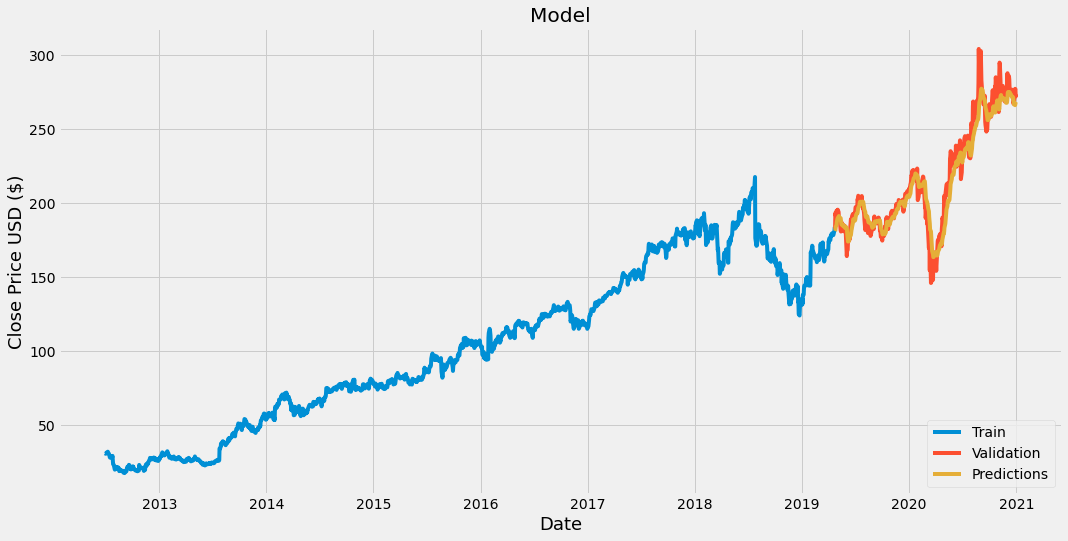

In [31]:
# plot the data
train = df[0:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [32]:
# Show the valid and predicted prices
valid = valid.filter(['Close', 'Predictions'])
valid

,Close,Predictions
Date,,
2019-04-24,182.580002,181.074677
2019-04-25,193.259995,181.553070
2019-04-26,191.490005,183.622986
2019-04-29,194.779999,185.297516
2019-04-30,193.399994,187.315094
...,...,...
2020-12-24,267.399994,266.503265
2020-12-28,277.000000,265.984894
2020-12-29,276.779999,266.947021


In [33]:
# get a quote
fb_quote = web.DataReader(TICKER, data_source='yahoo',        start='2012-01-01', end='2021-01-05')
# add technical indicators to quote
# add to the data set
MACD(fb_quote)
RSI(fb_quote)
fb_quote['SMA'] = SMA(fb_quote)
fb_quote['EMA'] = EMA(fb_quote)

# Create a new df
new_df = fb_quote.filter(['Close', 'MACD', 'Signal_Line', 'RSI', 'SMA', 'EMA'])
# get the last 60 closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# append the past 60 days to X_test
X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
X_test = np.array(X_test)
# get the predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[:, 0:1]
print(pred_price)

[[267.61768]]


In [34]:
fb_quote2 = web.DataReader(TICKER, data_source='yahoo', start='2021-01-06', end='2021-01-06')
print(fb_quote2['Close'])

Date
2021-01-06    263.309998
Name: Close, dtype: float64
